# Ridge regression

The FANTOM5 CAGE experiments do not contain cell lines or tissues that allow for a one-to-one matching to the cell types from mouse gastrulation. One way to make predictions with the output tracks from Basenji2 is to fit a regularized regression model to predict gene expression for each mouse gastrulation cell type, as described by Karollus et al (2022).

The gene expression for a specific gene in a specific cell type is a linear combination of the gene expression levels of all CAGE experiments. 

In [1]:
import pickle
#import pybedtools
import os
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import kipoiseq
import matplotlib.pyplot as plt
import torch    


from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

from ridge_regression_encode_utils import *

/data/mikulik/miniconda3/envs/transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-01 10:14:48.242184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = "/data/mikulik/mnt/gcs_basenj/"
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")

Using: cpu
Number of GPUs available: 0


Read in the mouse gastrulation scRNA-seq data set. Below you can see how many cells and genes are found in the count matrix. 

In [3]:
cage_sub = sc.read_h5ad(os.path.join(data_dir, "mouse_rna_seq_gastrulation_processing", "rna_sub.h5ad"))
print(f"Number of cells: {cage_sub.shape[0]}, number of genes: {cage_sub.shape[1]}")

Number of cells: 65420, number of genes: 31440


/data/mikulik/miniconda3/envs/transformer/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Read in the input regions.

In [4]:
save = False
region_df = pd.read_csv(os.path.join(data_dir, "mouse", "sequences.bed"), sep="\t", header=None)
region_df.columns = ["chrom", "start", "end", "subset"]
region_df.reset_index(inplace=True)
region_df = region_df[["chrom", "start", "end", "subset", "index"]]
# crop to center 114,688 bp
crop_bp = int((131_072 - 114_688) / 2)
print(f"crop {crop_bp} bp")
region_df.start = region_df.start + crop_bp
region_df.end = region_df.end - crop_bp
assert np.all(region_df.end - region_df.start == 114_688)
if save:
    region_bed = pybedtools.BedTool.from_dataframe(region_df)
    region_bed.saveas(os.path.join(data_dir,"mouse_rna_seq_gastrulation_processing", "mouse_input_sequences_basenji.bed"))

crop 8192 bp


The overlap between input regions and mouse gastrulation tss coordinates was computed on the cluster using: 
` python bedtools_overlap_karollus_tss.py mouse_gastrulation_gene_tss.bed mouse_input_sequences_basenji.bed overlap_mouse_gastrulation.bed /omics/groups/OE0540/internal/users/mikulik/master_thesis/data/gcs_basenj/mouse_rna_seq_gastrulation_processing`

# Matching
ENCODE does not contain cell lines that make a 1:1 matching to the cell types from mouse gastrualtion straight forward. To match mouse gastrulation cell types to ENCODE cell lines I will use Ridge REgression as described by Karollus et al. 

For each gene expressed in the mouse gastrulation RNA-seq count matrix I will extract the the mouse reference genome centered at the TSS. Using the Basenji and/or Enformer model I will make a prediction for gene expression for this sequence. 
I will predict the gene expression vector $g_{t} \in \mathbb{R}^n$ in cell type t. $g_{it}$ is the log-transformed expression of gene i in cell type t. $\beta^T \in \mathbb{R}^m$ is the vector of loearned weights for tissue t. $X_i \in \mathbb{R}^m$ is the vector of  Enformer/Basenji log-transformed predicted expression of gene i in ENCODE cell lines $m$. $X \in \mathbb{R}^{n \times m}$ is the matrix of predicted expression of all genes in all ENCODE cell lines. Both the gene expression values from ENCODE and mouse gastrulation are normalized by subtracting the mean for each cell line/cell type. The mean is only computed for the training set, but subtracted from both the training and test set. This way the model cannot learn tissue means which would also work for the test set. 

$$g_{it} = \beta^T_t X_i$$

$$g_t = \beta^T_t X$$


The training data consist of all genes overlapping with the trainign & validation regions of the mouse genome. The test data consist of all genes overlapping with the test regions of the mouse genome. The test set is used to evaluate the performance of the model. The training set is used to learn the weights $\beta^T$ for each cell type.


In ridge regression the objective function $||y - \beta^TX||^2_2 + \alpha * || \beta ||^2_2$ is minimized. 


In this example, the features are the ENCODE CAGE tracks and the samples are genes. It is important to standardize the features prior to training when performing ridge regression. However, the targets $g$ are not standardized. 

TODO: add column of highly variable genes!

Loading the RNA-seq count matrix from mouse gastrulation. 

In [5]:
overlap = pd.read_csv(os.path.join(data_dir, "mouse_gastrulation_tss_region_overlap.csv"))
count_mat = np.load(os.path.join(data_dir, "mouse_rna_seq_gastrulation_processing", "rna_lib_scaled.npy"))
cage_sub.var.rename(columns={"transcript_id": "gene_id"}, inplace=True)


1. Create the target vector $g_t \in \mathbb{R}^n$.
This target vector contains the gene expression counts (log-transformed) for all genes that overlap with either the train or validation regions of the Basenji2 dataset. 

In [6]:
g_train = create_target_vector(count_mat, ["train", "valid"], overlap)
g_test = create_target_vector(count_mat, ["test"], overlap)

use train and validation set
(37, 25861)
use test set
(37, 3380)


2. Create the matrix $X \in \mathbb{R}^mxn$ where $m$ is the number of ENCODE cell lines and $n$ is the number of genes.
This matrix contains the Enformer/Basenji predictions (log-transformed) for all genes that overlap with either the train or validation regions of the Basenji2 dataset. 

In [7]:
from data_utils_finetuning import *
mouse_fasta_path = "/data/mikulik/mnt/gcs_basenj/mm10.ml.fa"
fasta_reader = FastaStringExtractor(mouse_fasta_path)


### Load models to make predictions

In [8]:
# load trained Basenji model for predictions

from architecture_batchNorm_momentum import *
model_dir = "/data/mikulik/mnt/gcs_basenj/basenji_output/clean_slate/"
pretrained_model = "basenji_paper_param_real_data_no_it_corr_0.15_sgd_4_augmentTrue_model_validation_checkpoint"
num_dilated_conv = 11
num_conv = 6
conv_target_channels = 768
dilation_rate_init = 1
bn_momentum = .9
dilation_rate_mult = 1.5
experiments_human = 5313
experiments_mouse = 1643

basenji_model = BasenjiModel( 
                    n_conv_layers=num_conv,
                    n_dilated_conv_layers=num_dilated_conv, 
                    conv_target_channels=conv_target_channels,
                    bn_momentum=bn_momentum,
                    dilation_rate_init=dilation_rate_init, 
                    dilation_rate_mult=dilation_rate_mult, 
                    human_tracks=experiments_human, 
                    mouse_tracks=experiments_mouse)
basenji_model.load_state_dict(torch.load(os.path.join(model_dir, f"{pretrained_model}.pt"), map_location=torch.device("cpu")))


<All keys matched successfully>

In [9]:
# load trained Enformer model for predictions

import sys
sys.path.append('/data/mikulik/mnt/katformer/')
from architecture_linear import *
### LOAD MODEL
device="cpu"
enformer_path = os.path.join(data_dir, "train_enformer_month")
enformer_model = "enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict"
enformer_small = Enformer.from_hparams(
            dim = 1536,
            depth = 5,
            heads = 8,
            use_checkpointing=True,
            output_heads = dict(human = experiments_human, mouse= experiments_mouse),
            target_length = 896,
        )
enformer_small.load_state_dict(torch.load(os.path.join(enformer_path, f"{enformer_model}.pt"), map_location=torch.device("cpu")))
enformer_small.to(device)

Enformer(
  (stem): Sequential(
    (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Residual(
      (fn): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (2): AttentionPool(
      (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
      (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (conv_tower): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(1,), stri

In [10]:
#device = "cpu"
#gex_enformer_small = get_gene_expression_predictions(enformer_small, model_name="enformer", subset=["train", "valid"], seq_length=196_608, center_bin=896//2, recompute=True, overlap=overlap, device=device, file_name='/data/mikulik/mnt/gcs_basenj/gex_enformer_small_training_set.csv')
#gex_enformer_small_test = get_gene_expression_predictions(enformer_small, model_name="enformer", subset=["test"], seq_length=196_608, center_bin=896//2, recompute=True, overlap=overlap, device=device,  file_name='/data/mikulik/mnt/gcs_basenj/gex_enformer_small_test_set.csv')


In [11]:
gex_basenji = get_gene_expression_predictions(basenji_model, model_name="basenji", subset =["train", "valid"], seq_length=131_072, center_bin=896//2, recompute=False, overlap=overlap, file_name='/data/mikulik/mnt/gcs_basenj/gex_basenji_training_set.csv')
gex_basenji_test = get_gene_expression_predictions(basenji_model, model_name="basenji",  subset=["test"], seq_length=131_072, center_bin=896//2, recompute=False, overlap=overlap, file_name='/data/mikulik/mnt/gcs_basenj/gex_basenji_test_set.csv')


It is really important to make sure that the samples (genes) are in the correct order. 

In [12]:
gex_basenji = gex_basenji.reindex(columns= g_train.columns)
gex_basenji_test = gex_basenji_test.reindex(columns=g_test.columns)
assert (gex_basenji.columns == g_train.columns).all()
assert (gex_basenji_test.columns == g_test.columns).all()

4. Normalization of features

* log-transform + 1
* subst to contain only CAGE tracks
* Standardize such that all features have mean 0 and std 1

In [13]:
x_norm, x_norm_test = normalize_gex_predictions(gex_basenji, gex_basenji_test)

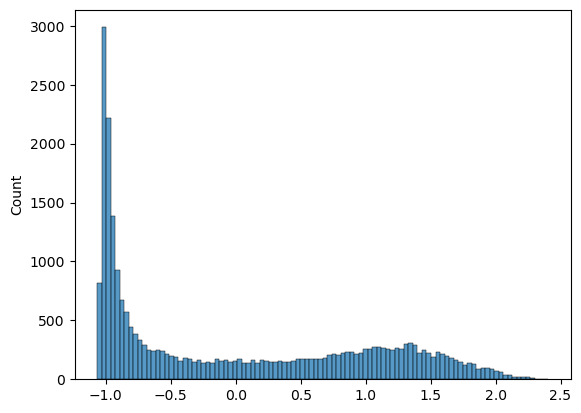

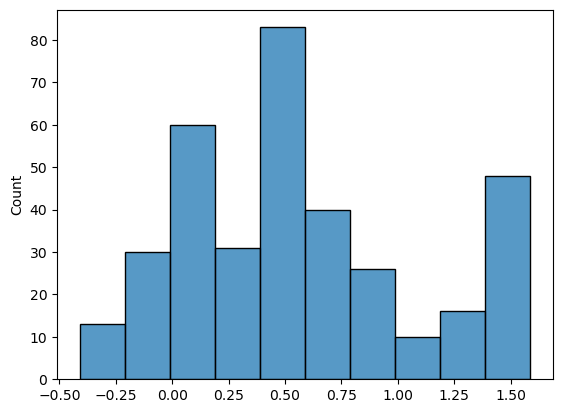

<Axes: ylabel='Count'>

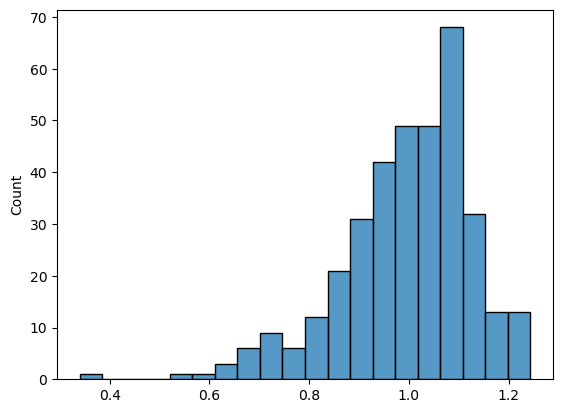

In [14]:
sns.histplot(x_norm[0, :], bins=100) # distribution of gen eexpression values across all genes for CAGE track 0
plt.show()
sns.histplot(x_norm[:, 0]) # distribution gene expression values across all CAGE tracks
plt.show()
sns.histplot(x_norm_test[:, 0])

## Fit the ridge regression model

In [15]:
g_train, g_test = np.array(g_train), np.array(g_test)

In [16]:
rna_target_df = pd.read_csv(os.path.join(data_dir, "rna_targets_gastrulation_df.txt"), index_col=0)
target_df = pd.read_csv(os.path.join(data_dir, "mouse", "targets.txt"), sep="\t")
cage_targets = target_df[target_df.description.str.contains("CAGE")]
cage_targets.reset_index(inplace=True)


The best way to select a hyperparameter set is to perform cross-validation! This needs to be done!

In [17]:
#corr_test, corr_train = [], []
#for j in [0, 0.1, 0.5, 0.8, 1, 1.5, 2, 2.5, 3]:
#    print(f"Alpha: {j}")
#    for i in range(37):
#        lr = Ridge(alpha=j)
#        lr.fit(x_norm.T, g_train[i, :])
#        #print(f"ENCODE: {cage_targets.iloc[np.argmax(lr.coef_), :].description}")
#        #print(f"Gastrulation celltype: {rna_target_df.iloc[i, :].celltype}")
#        pred_test = lr.predict(x_norm_test.T)
#        pred_train = lr.predict(x_norm.T)
#        corr_test.append(np.corrcoef(pred_test, g_test[i, :])[0, 1])
#        corr_train.append(np.corrcoef(pred_train, g_train[i, :])[0, 1])
#        print(f"{rna_target_df.iloc[i, :].celltype}, {cage_targets.iloc[np.argmax(lr.coef_), :].description}" )
#        #print(f"Gastrulation celltype: {rna_target_df.iloc[i, :].celltype}")

In [18]:
print(x_norm.shape, x_norm_test.shape, g_train.shape, g_test.shape)

(357, 25861) (357, 3380) (37, 25861) (37, 3380)


Below we can see that the best match is achieved by "gonad, embryo E13" across most cell types.

In [22]:
corr_test, corr_train = [], []

for i in range(37):
    lr = Ridge(alpha=1)
    lr.fit(x_norm.T, g_train[i, :])
    #print(f"ENCODE: {cage_targets.iloc[np.argmax(lr.coef_), :].description}")
    #print(f"Gastrulation celltype: {rna_target_df.iloc[i, :].celltype}")
    pred_test = lr.predict(x_norm_test.T)
    pred_train = lr.predict(x_norm.T)
    corr_test.append(np.corrcoef(pred_test, g_test[i, :])[0, 1])
    corr_train.append(np.corrcoef(pred_train, g_train[i, :])[0, 1])
    print(f"{rna_target_df.iloc[i, :].celltype}, {cage_targets.iloc[np.argmax(lr.coef_), :].description}" )
    #print(f"Gastrulation celltype: {rna_target_df.iloc[i, :].celltype}")

Caudal_epiblast, CAGE:gonad, embryo E13
ExE_ectoderm, CAGE:gonad, embryo E13
Mixed_mesoderm, CAGE:gonad, embryo E13
Primitive_Streak, CAGE:gonad, embryo E13
Parietal_endoderm, CAGE:gonad, embryo E13
Somitic_mesoderm, CAGE:gonad, embryo E13
Gut, CAGE:gonad, embryo E13
Blood_progenitors_1, CAGE:gonad, embryo E13
Rostral_neurectoderm, CAGE:gonad, embryo E13
Visceral_endoderm, CAGE:gonad, embryo E13
ExE_endoderm, CAGE:gonad, embryo E13
Nascent_mesoderm, CAGE:gonad, embryo E13
Haematoendothelial_progenitors, CAGE:gonad, embryo E13
Def._endoderm, CAGE:gonad, embryo E13
Caudal_Mesoderm, CAGE:gonad, embryo E13
Epiblast, CAGE:gonad, embryo E13
Mesenchyme, CAGE:gonad, embryo E13
Blood_progenitors_2, CAGE:gonad, embryo E13
Paraxial_mesoderm, CAGE:gonad, embryo E13
Anterior_Primitive_Streak, CAGE:gonad, embryo E13
Surface_ectoderm, CAGE:gonad, embryo E13
Pharyngeal_mesoderm, CAGE:gonad, embryo E13
Notochord, CAGE:ovary, adult
Intermediate_mesoderm, CAGE:gonad, embryo E13
PGC, CAGE:pituitary gland,

In [23]:
coeffs, ridge_pred_matrix = fit_ridge_regression_per_celltype(x_norm.T, x_norm_test.T, g_train, g_test, alpha=1)

Number of celltypes: 37


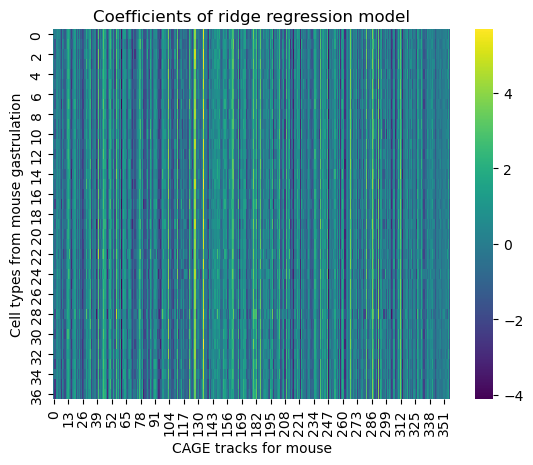

In [24]:
sns.heatmap(coeffs, cmap="viridis")
plt.title("Coefficients of ridge regression model")
plt.xlabel("CAGE tracks for mouse")
plt.ylabel("Cell types from mouse gastrulation")
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/", "ridge_coeffs.pdf"), format="pdf")
plt.show()

In [25]:
from evaluate import * 

#### cross-gene correlations of ridge regression predictions for mouse gastrulation cell types

0.2844631308221718


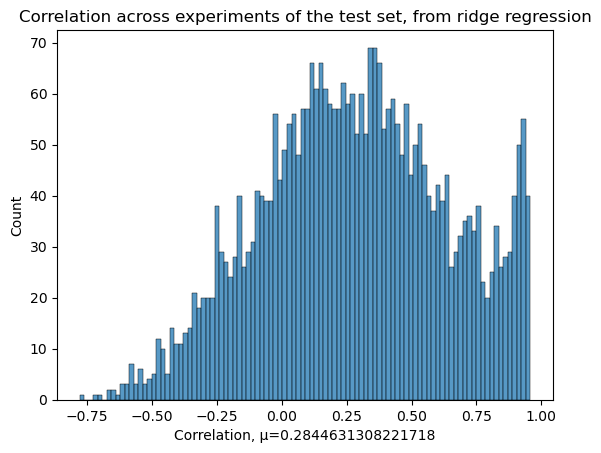

In [27]:
a, b = standardize_matrix_columns(ridge_pred_matrix.T, log=False), standardize_matrix_columns(g_test.T, log=False)
cross_celltype_ridge  = pearson_corr(a.T, b.T, per_column=True, log=False)
print(cross_celltype_ridge.mean())
sns.histplot(cross_celltype_ridge, bins=100)
plt.xlabel(f"Correlation, µ={cross_celltype_ridge.mean()}")
plt.title(f"Correlation across experiments of the test set, from ridge regression")
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/", "cross_celltype_ridge.pdf"), format="pdf")
plt.show()

#### cross-celltype correlations of ridge regression predictions for genes in test set

0.7857413341363353


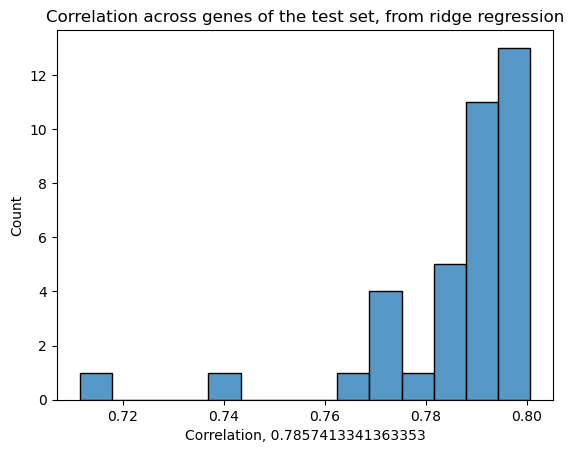

In [28]:
cross_genes_ridge = pearson_corr(ridge_pred_matrix.T, g_test.T, per_column=True, log=False)
print(cross_genes_ridge.mean())
sns.histplot(cross_genes_ridge)
plt.xlabel(f"Correlation, {cross_genes_ridge.mean()}")
plt.title("Correlation across genes of the test set, from ridge regression")
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/", "cross_genes_ridge.pdf"), format="pdf")

In [30]:
import pickle
save = False
if save:
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "rna_tar_joint_finetune_cage.pkl"), "wb") as f:
        pickle.dump(rna_tar, f)
else:
    with open(os.path.join(data_dir, "finetune_output/correlation_cage", "rna_tar_joint_finetune_cage.pkl"), "rb") as f:
        rna_tar_joint = pickle.load(f)

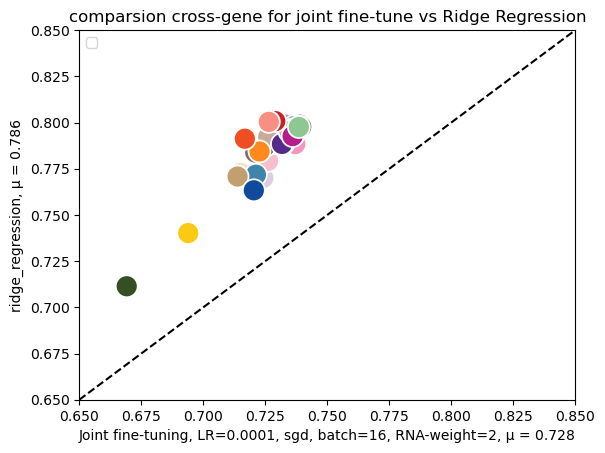

In [31]:
key_joint = "joint_0.0001_sgd_16_augmentTrue_atac35_rna37_batch16_logtransformFalse_loss_weight2.0"
finetune_values = rna_tar_joint[key_joint]#

unique_colors = rna_tar_joint['color'].unique()
# Create a custom color palette
custom_palette = sns.color_palette(unique_colors)
# Set the custom palette
sns.set_palette = custom_palette

sns.scatterplot(rna_tar_joint,x=finetune_values, y=cross_genes_ridge,
                hue="celltype", s=250, palette=custom_palette)
sns.lineplot(x=[0.65,0.85], y=[0.65,0.85], color="black", linestyle='--')
#sns.barplot(data=atac_tar, x="celltype", y=f"{name}_corr", palette=atac_tar["color"])#, color="blue")
plt.ylabel(f"ridge_regression, µ = {cross_genes_ridge.mean():.3f}")
plt.title("comparsion cross-gene for joint fine-tune vs Ridge Regression")
plt.xlabel(f"Joint fine-tuning, LR=0.0001, sgd, batch=16, RNA-weight=2, µ = {finetune_values.mean():.3f}")
#plt.xticks(rotation=90)
plt.legend([])
plt.ylim([0.65,0.85])
plt.xlim([0.65,0.85])
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/",  'finetune_ridge_regression_cross_gene_comparison.pdf'), format='pdf')
plt.show()


In [32]:
with open(os.path.join(data_dir, "finetune_output/correlation_cage", "joint_corr.pkl"), "rb") as f:
    corr_exp_dict_joint = pickle.load(f)

In [33]:
finetune_exp_values = corr_exp_dict_joint[key_joint]
finetune_exp_values.shape

(3380,)

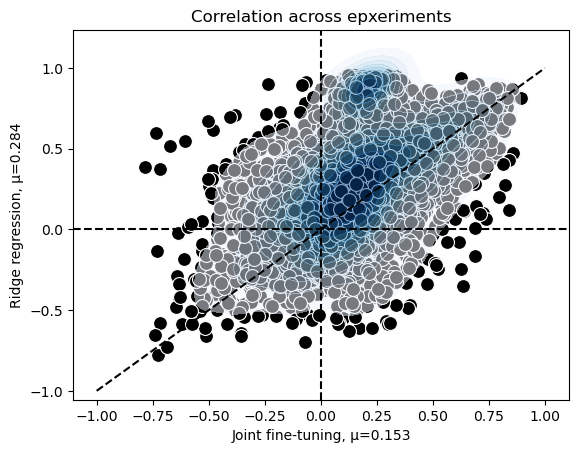

In [34]:
a,b = corr_exp_dict_joint[key_joint], cross_celltype_ridge
sns.scatterplot(x=a, y=b, color="black", s=100)
sns.kdeplot(x=a, y=b, fill=True, alpha=0.5, cmap="Blues")
plt.axhline(y=0, color="black", linestyle="--")
plt.axvline(x=0, color="black", linestyle="--")
sns.lineplot(x=[-1, 1], y=[-1, 1], color="black", linestyle='--')
#plt.ylim(-0.8, 0.85)
#plt.xlim(-0.8, 0.85)
plt.title("Correlation across epxeriments")
plt.xlabel(f"Joint fine-tuning, µ={a.mean():.3f}")
plt.ylabel(f"Ridge regression, µ={b.mean():.3f}")
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/", "finetune_ridge_regression_cross_exp_comparison.pdf"), format="pdf")
plt.show()

To make sure that the alpha parameter of the ridge regression does not have too big of an influence I tried different values. Below you can see that the mean correlation for across all mouse gastrulation cell types stayed pretty much the same. 

In [35]:

for j in [0, 0.1, 0.5, 0.8, 1, 1.5, 2, 2.5, 3]:
    corrs = []
    for i in range(37):
        lr = Ridge(alpha=j)
        lr.fit(x_norm.T, g_train[i, :])
        #print(f"ENCODE: {cage_targets.iloc[np.argmax(lr.coef_), :].description}")
        #print(f"Gastrulation celltype: {rna_target_df.iloc[i, :].celltype}")
        pred = lr.predict(x_norm_test.T)
        corrs.append(np.corrcoef(pred, g_test[i, :])[0, 1])
        #print(corrs)
    print(f"alpha: {j}, mean corr: {np.array(corrs).mean()}")

alpha: 0, mean corr: 0.7853904748582451
alpha: 0.1, mean corr: 0.7855791538484875
alpha: 0.5, mean corr: 0.7857854446781861
alpha: 0.8, mean corr: 0.7857742951974718
alpha: 1, mean corr: 0.7857413341363351
alpha: 1.5, mean corr: 0.7856203003757769
alpha: 2, mean corr: 0.7854760149824755
alpha: 2.5, mean corr: 0.7853246741826202
alpha: 3, mean corr: 0.7851726677881553


## Biological interpretation of the ridge regression coefficients

The correlations are reasonably high for the test set. The highest coefficients seems to be gonad from embryo E13? Interpreting the coefficients of this model seems very tricky. 

I will explore the tissues from embryo that can be found in the mouse ENCODE tracks. 

In [37]:
#cage_targets.reset_index(inplace=True)
tissues = cage_targets[cage_targets.description.str.contains("embryo")].description.str.split(",", expand=True)#.iloc[:, 0].value_counts(
tissues.columns=["tissue", "stage", "extra"]
tissues[["exp", "tissues"]] = tissues.tissue.str.split(":", expand=True)
tissues[["emp", "embryo", "stage"]]=tissues.stage.str.split(" ", expand=True)
print("unique tissues:", tissues.tissues.nunique())
print("unique stages:", tissues.stage.nunique())
print(tissues.tissues.unique())
print(tissues.stage.unique())

unique tissues: 18
unique stages: 10
['liver' 'whole body' 'eyeball' 'lung' 'intestine' 'forelimb' 'pancreas'
 'thymus' 'kidney' 'heart' 'stomach' 'pituitary gland' 'adrenal gland'
 'spleen' 'testis' 'ovary' 'gonad' 'cerebellum']
['E17' 'E13' 'E17.5' 'E16' 'E18' 'E14' 'E15' 'E12' 'E14.5' 'E11']


In [38]:
tissues[tissues.stage == "E11"]

,tissue,stage,extra,exp,tissues,emp,embryo
69,CAGE:heart,E11,None,CAGE,heart,,embryo
77,CAGE:forelimb,E11,None,CAGE,forelimb,,embryo
107,CAGE:whole body,E11,None,CAGE,whole body,,embryo
272,CAGE:cerebellum,E11,biol_ (E11R1),CAGE,cerebellum,,embryo
281,CAGE:cerebellum,E11,biol_ (E11R2),CAGE,cerebellum,,embryo
293,CAGE:cerebellum,E11,biol_ (E11R3),CAGE,cerebellum,,embryo


In [39]:
tissues[tissues.stage == "E12"]

,tissue,stage,extra,exp,tissues,emp,embryo
54,CAGE:lung,E12,None,CAGE,lung,,embryo
70,CAGE:whole body,E12,None,CAGE,whole body,,embryo
71,CAGE:stomach,E12,None,CAGE,stomach,,embryo
81,CAGE:forelimb,E12,None,CAGE,forelimb,,embryo
82,CAGE:liver,E12,None,CAGE,liver,,embryo
108,CAGE:heart,E12,None,CAGE,heart,,embryo
109,CAGE:eyeball,E12,None,CAGE,eyeball,,embryo
111,CAGE:pituitary gland,E12,None,CAGE,pituitary gland,,embryo
112,CAGE:intestine,E12,None,CAGE,intestine,,embryo
273,CAGE:cerebellum,E12,biol_ (E12R1),CAGE,cerebellum,,embryo


In [40]:
tissues[tissues.stage == "E13"]

,tissue,stage,extra,exp,tissues,emp,embryo
44,CAGE:whole body,E13,None,CAGE,whole body,,embryo
56,CAGE:liver,E13,None,CAGE,liver,,embryo
72,CAGE:forelimb,E13,None,CAGE,forelimb,,embryo
102,CAGE:pituitary gland,E13,None,CAGE,pituitary gland,,embryo
103,CAGE:intestine,E13,None,CAGE,intestine,,embryo
106,CAGE:heart,E13,None,CAGE,heart,,embryo
123,CAGE:testis,E13,None,CAGE,testis,,embryo
135,CAGE:gonad,E13,None,CAGE,gonad,,embryo
274,CAGE:cerebellum,E13,biol_ (E13R1),CAGE,cerebellum,,embryo
283,CAGE:cerebellum,E13,biol_ (E13R2),CAGE,cerebellum,,embryo


Judging from the data above, one would assume that there are much better matches for certain mouse gastrualtion cell types than "gonad". For example heart should match to cardiomyocytes or gut to intestines. At least intuitively. This is however not what the model tells us. 

We can plot the coefficients of the ridge regression model in a heatmap to see if other experiments also get high coefficients?

We can immediately see that the coefficients are largely very similar across different cell types of mouse gastrulation (y-axis). This probably means that differences between individual cell types are very hard to learn for any model. 

In [41]:
def standardardize_matrix_per_row(mat):
    mat_norm = (mat - mat.mean(axis=1)[:, None]) / mat.std(axis=1)[:, None]
    assert np.isclose(mat_norm.mean(axis=1), 0).all()
    assert np.isclose(mat_norm.std(axis=1), 1).all()
    return mat_norm

<Axes: >

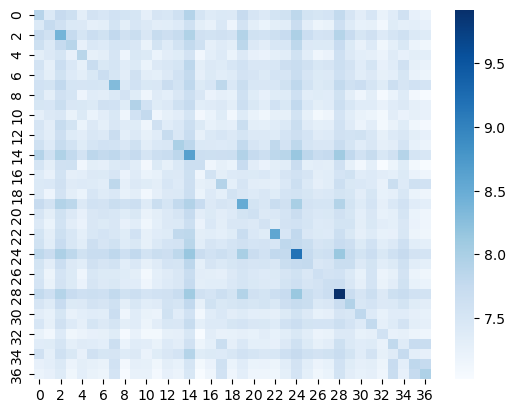

In [42]:
sns.heatmap(np.cov(g_train), cmap="Blues")

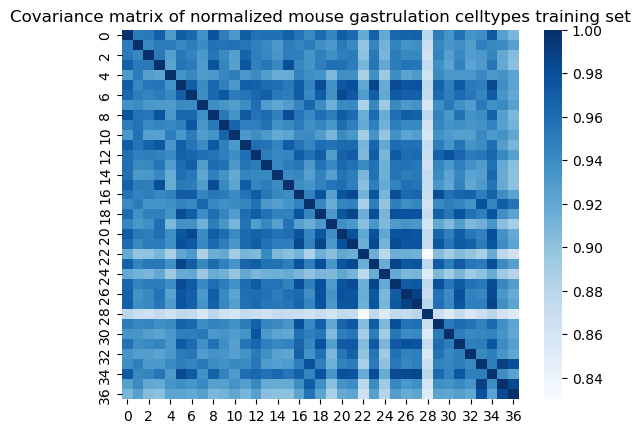

In [44]:
g_train_norm = standardardize_matrix_per_row(g_train)
sns.heatmap(np.cov(g_train_norm), cmap="Blues")
plt.title("Covariance matrix of normalized mouse gastrulation celltypes training set")
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/" "cov_gastrulation_mouse.pdf"), format="pdf")
plt.show()
#sns.heatmap(np.cov(g_train_norm), cmap="viridis")
#plt.show()

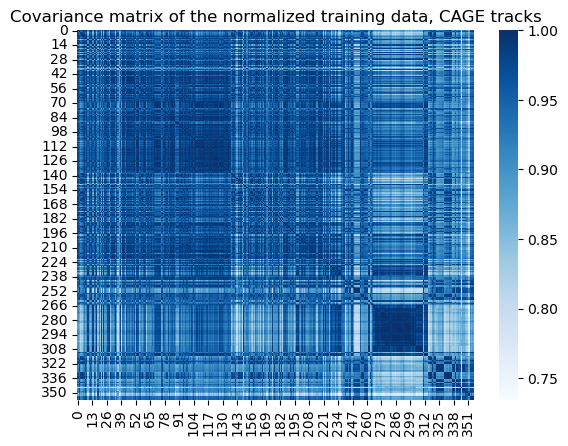

In [45]:
cov = np.cov(x_norm)
sns.heatmap(cov, cmap="Blues")
plt.title("Covariance matrix of the normalized training data, CAGE tracks")
plt.savefig(os.path.join(data_dir, "plots/finetune_rna/", "cov_cage_mouse.pdf"), format="pdf")
plt.show()

#cov = np.cov(x_norm_test)
#sns.heatmap(cov, cmap="viridis")

Text(50.722222222222214, 0.5, 'mouse gastrulation cell types')

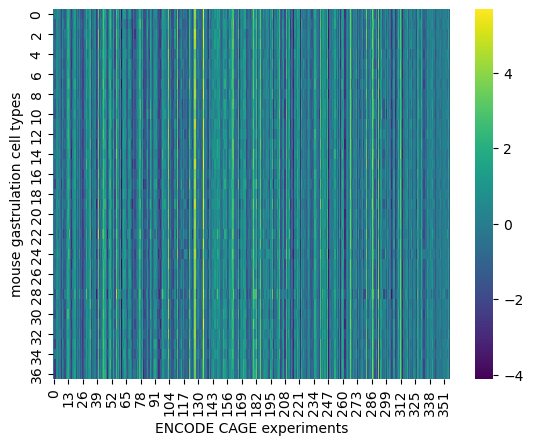

In [46]:
sns.heatmap(coeffs, cmap="viridis")
plt.xlabel("ENCODE CAGE experiments")
plt.ylabel("mouse gastrulation cell types")